In [ ]:
import pandas as pd

# Specify the file path
file_path = "dataset.xlsx"  # Adjust if the file name is different

# Read the "Data" sheet from the Excel file
data = pd.read_excel(file_path, sheet_name="Data", header=None)  # Using header=None for raw structure

In [ ]:
# Adjust display options
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.max_colwidth', None)  # Show full width of columns
pd.set_option('display.width', 1000)  # Adjust the display width

In [ ]:
data.iloc[0] = data.iloc[0].fillna('')
data.iloc[1] = data.iloc[1].fillna('')

# Combine the two rows to create headers
data.columns = [f"{str(data.iloc[0, col])} {str(data.iloc[1, col])}".strip() for col in range(data.shape[1])]

# Drop the first two rows (now part of headers)
data = data[2:].reset_index(drop=True)

# Display the cleaned dataset
print(data.head().to_markdown(index=False))

In [ ]:
import numpy as np

# Define a function to convert object columns to appropriate types
def convert_column_types(df):
    numeric_columns = [
        'Condition', 'Activity code', 'Participant', 'Sex', 'Age', 'Bodymasskg', 'Heightcm',
        'Bodyfat%', 'VO2peakmlkgmin', 'Acclimationstatus', 'Trainingstatus', 'Clothing',
        'Temp', 'Wind', 'Rhfront', 'Tback', 'Rhback', 'Activity workrest','OxygenConsumption ml.kg.min',
        'Core Temp',
        'SkinTemp hand', 'BR', 'HR', 'HRtype',
        'Perceptual TS', 'TC', 'TP', 'SW', 'RPE', 'R-Rintmanual', 'SDRRManual',
        'HRV RMSSDmanual', 'R-R intsoftware', 'SDRRSoftware', 'RMSSDSoftware'
    ]

    for col in numeric_columns:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce')  # Convert to numeric, replacing errors with NaN

    return df

# Apply conversion function
data = convert_column_types(data)

data['Time'] = pd.to_datetime(data['Time'], format='%H:%M:%S').dt.time

# Replace 9999 with NaN
data.replace(9999, np.nan, inplace=True)

# Display dataset information after conversion
print("Data types after conversion:")
data.info()

# Preview cleaned data
print("\nCleaned Data Preview:")
print(data.head().to_markdown(index=False))

In [ ]:
# List of critical columns for interpolation
critical_columns = [
    'HR', 'CoreTemp', 'SkinTemp hand'
]

# Interpolating missing values for critical columns
data[critical_columns] = data[critical_columns].interpolate(method='linear').fillna(method='bfill').fillna(method='ffill')

# Filling remaining numeric columns with forward and backward fill
data = data.fillna(method='bfill').fillna(method='ffill')

# Display the cleaned dataset preview
print("\nDataset after filling missing values:")
print(data.head().to_markdown(index=False))

# Check remaining missing values
missing_summary = data.isnull().sum()
print("\nRemaining Missing Values by Column:")
print(missing_summary[missing_summary > 0])

###EDA

In [ ]:
# Check for duplicate timestamps within each participant, considering Condition and Activity code
duplicate_timestamps = data.duplicated(subset=['Participant', 'Time', 'Condition', 'Activity code'], keep=False)

if duplicate_timestamps.any():
    print("Duplicate timestamps found with potentially different conditions or activities:")
    duplicates = data.loc[duplicate_timestamps, ['Participant', 'Time', 'Condition', 'Activity code']]
    # Sort duplicates for better clarity
    duplicates = duplicates.sort_values(by=['Participant', 'Time', 'Condition', 'Activity code'])
    print(duplicates.to_markdown(index=False))
else:
    print("No duplicate timestamps found for any participant, condition, and activity combination.")

No duplicate timestamps found for any participant, condition, and activity combination.


In [ ]:
# Total number of participants
total_participants = data['Participant'].nunique()
print(f"Total Participants: {total_participants}")

# Unique conditions per participant
conditions_per_participant = data.groupby('Participant')['Condition'].nunique()
print("\nNumber of unique conditions per participant:")
print(conditions_per_participant)

# Unique activity codes per participant and condition
activity_codes_per_participant_condition = (
    data.groupby(['Participant', 'Condition'])['Activity code'].nunique()
)
print("\nNumber of unique activity codes per participant and condition:")
print(activity_codes_per_participant_condition)

# Summary of activity codes per condition
activity_code_summary = (
    data.groupby('Condition')['Activity code'].nunique().reset_index(name='Unique Activity Codes')
)
print("\nSummary of unique activity codes per condition:")
print(activity_code_summary)

# Check for duplicate timestamps for each participant and condition
duplicates_per_participant_condition = (
    data.duplicated(subset=['Participant', 'Time', 'Condition'], keep=False).sum()
)
print(f"\nNumber of duplicate timestamps for each participant and condition: {duplicates_per_participant_condition}")

# Suggestion for subset selection based on conditions and activity codes
subset_suggestion = (
    data.groupby(['Condition', 'Activity code'])
    .size()
    .reset_index(name='Count')
    .sort_values(by='Count', ascending=False)
)
print("\nPotential subsets based on Condition and Activity code distribution:")
print(subset_suggestion.head(10))

Total Participants: 40

Number of unique conditions per participant:
Participant
1     3
2     3
3     3
4     3
5     3
6     2
7     3
8     3
9     3
10    3
11    3
12    3
13    3
14    3
15    3
16    3
17    3
18    3
29    6
30    5
31    5
32    5
33    6
34    5
35    6
36    5
37    5
38    6
39    6
40    2
41    5
42    5
43    6
44    6
45    5
46    1
47    4
48    4
49    3
50    1
Name: Condition, dtype: int64

Number of unique activity codes per participant and condition:
Participant  Condition
1            1            6
             2            6
             3            6
2            1            6
             2            3
                         ..
48           11           6
49           7            6
             8            6
             11           6
50           10           6
Name: Activity code, Length: 155, dtype: int64

Summary of unique activity codes per condition:
   Condition  Unique Activity Codes
0          1                      8
1     

Basic Statistics:
|        |   Participant |   Condition | Time     |         HR |   SkinTemp abdomen |   SkinTemp calf |   SkinTemp chest |   SkinTemp foot |   SkinTemp hand |   SkinTemp head |   SkinTemp lower arm |   SkinTemp lower back |   SkinTemp thigh |   SkinTemp upper arm |   SkinTemp upper back |     CoreTemp |        Δcore |
|:-------|--------------:|------------:|:---------|-----------:|-------------------:|----------------:|-----------------:|----------------:|----------------:|----------------:|---------------------:|----------------------:|-----------------:|---------------------:|----------------------:|-------------:|-------------:|
| count  |    17264      | 17264       | 17264    | 17264      |        17264       |     17264       |      17264       |     17264       |     17264       |     17264       |           17264      |           17264       |      17264       |          17264       |           17264       | 17264        | 17264        |
| unique |      nan   

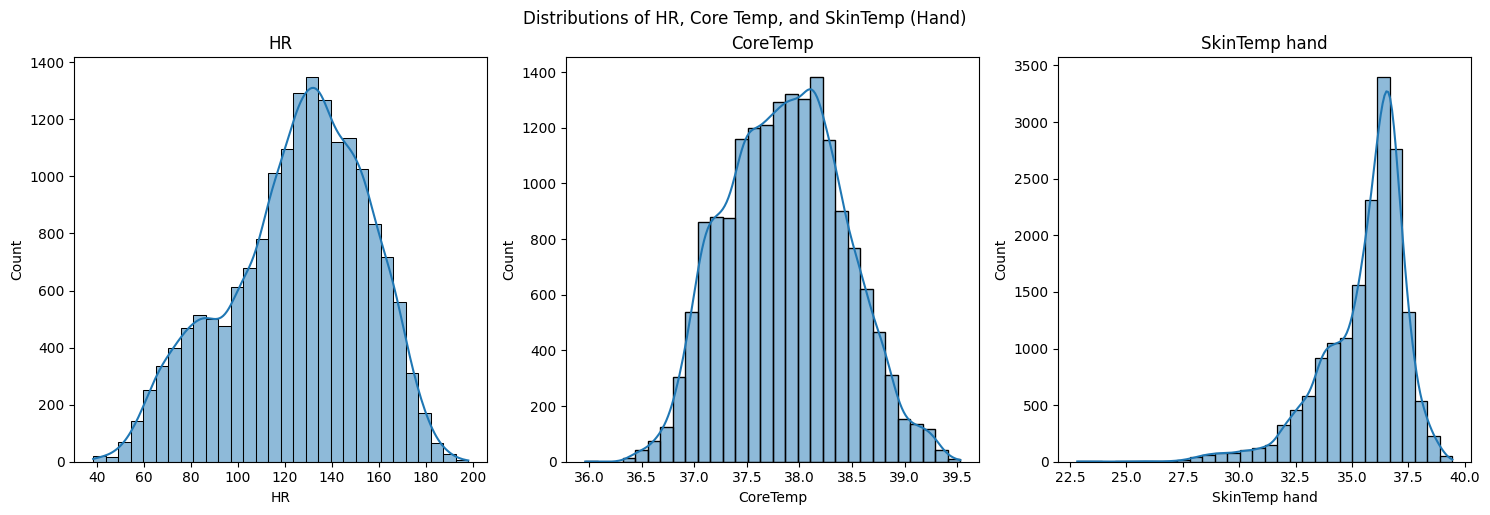

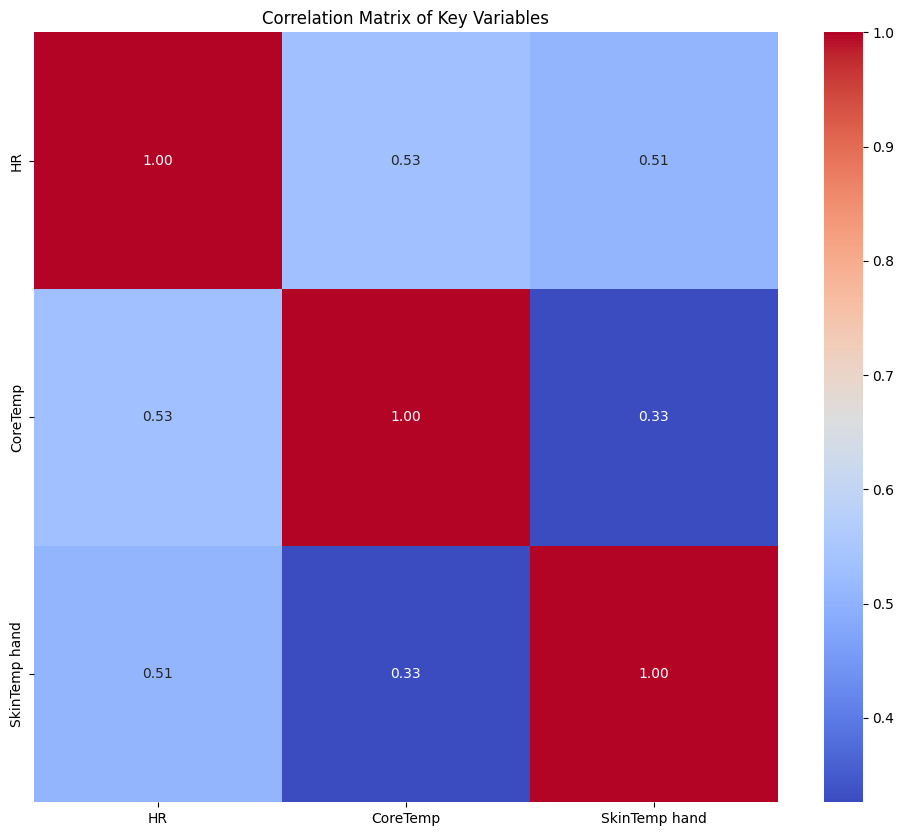


Time Series Analysis:
|        | 0         |
|:-------|:----------|
| (1, 1) | (0, True) |
| (1, 2) | (0, True) |
| (1, 3) | (0, True) |
| (2, 1) | (0, True) |
| (2, 2) | (0, True) |
| (2, 3) | (0, True) |
| (3, 1) | (0, True) |
| (3, 2) | (0, True) |
| (3, 3) | (0, True) |
| (4, 1) | (0, True) |


<ipython-input-38-f178fcda2c77>:61: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  time_series_analysis = data.groupby(["Participant", "Condition"]).apply(


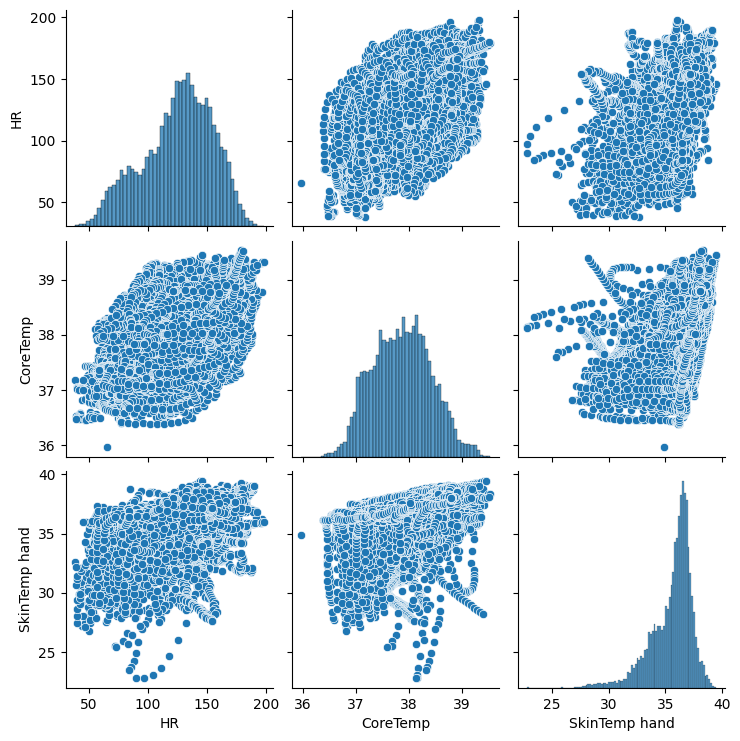


Outliers in SkinTemp Columns:
SkinTemp hand: 583 outliers


<ipython-input-38-f178fcda2c77>:94: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset["Time"] = pd.to_datetime(subset["Time"], format='%H:%M:%S')  # Adjust format if needed


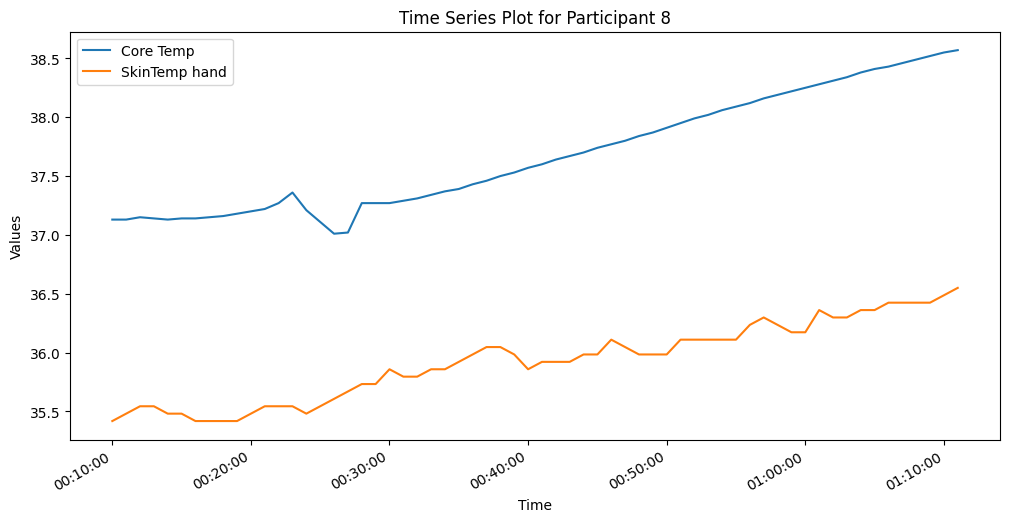

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import matplotlib.dates as mdates


# Replace 'old_column_name' with 'new_column_name'
data = data.rename(columns={'CoreTemp': 'CoreTemp'})


# Subset of columns of interest
key_columns = [
    "Participant", "Condition", "Time", "HR", "SkinTemp hand","CoreTemp", "Δcore"
]

# Check basic statistics
print("Basic Statistics:")
print(data[key_columns].describe(include='all').to_markdown())

# Missing data summary
print("\nMissing Data Summary:")
missing_data = data[key_columns].isna().sum()
print(missing_data[missing_data > 0].sort_values(ascending=False).to_markdown())

# Distribution plots for key variables
def plot_distributions(df, cols, title="Distribution Plots"):
    plt.figure(figsize=(15, 5))
    for i, col in enumerate(cols, 1):
        plt.subplot(1, len(cols), i)
        sns.histplot(df[col], kde=True, bins=30)
        plt.title(col)
        plt.tight_layout()
    plt.suptitle(title, y=1.02)
    plt.show()

plot_distributions(data, ["HR", "CoreTemp", "SkinTemp hand"], title="Distributions of HR, Core Temp, and SkinTemp (Hand)")



numerical_cols = [
    "HR", "CoreTemp", "SkinTemp hand"
]
correlation_matrix = data[numerical_cols].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Correlation Matrix of Key Variables")
plt.show()

# Check time series consistency
print("\nTime Series Analysis:")
time_series_analysis = data.groupby(["Participant", "Condition"]).apply(
    lambda x: (x["Time"].duplicated().sum(), x["Time"].is_monotonic_increasing)
)
time_series_analysis.columns = ["Duplicate Time Count", "Is Time Monotonic"]
print(time_series_analysis.head(10).to_markdown())

# Pairplots for Core Temperature and HR vs. SkinTemps
sns.pairplot(data, vars=["HR", "CoreTemp", "SkinTemp hand"])
plt.show()

# Check for outliers in SkinTemp columns
print("\nOutliers in SkinTemp Columns:")
for col in [col for col in numerical_cols if "SkinTemp" in col]:
    q1 = data[col].quantile(0.25)
    q3 = data[col].quantile(0.75)
    iqr = q3 - q1
    outliers = data[(data[col] < (q1 - 1.5 * iqr)) | (data[col] > (q3 + 1.5 * iqr))]
    print(f"{col}: {len(outliers)} outliers")

# Visualize trends over time for one participant and condition
#participant = data["Participant"].iloc[0]
#condition = data["Condition"].iloc[0]
#subset = data[(data["Participant"] == participant) & (data["Condition"] == condition)]
# Visualize trends over time for one participant and condition
participant = data["Participant"].iloc[0]
condition = data["Condition"].iloc[0]
subset = data[(data["Participant"] == 8) & (data["Condition"] == 2) & (data["Activity code"] == 5)]



import matplotlib.dates as mdates

# Convert 'Time' to datetime for proper formatting
subset["Time"] = pd.to_datetime(subset["Time"], format='%H:%M:%S')  # Adjust format if needed

plt.figure(figsize=(12, 6))
for col, name in zip(["CoreTemp", "SkinTemp hand"], ["Core Temp", "SkinTemp hand"]):
    plt.plot(subset["Time"], subset[col], label=name)

plt.xlabel("Time")
plt.ylabel("Values")
plt.title(f"Time Series Plot for Participant 8")
plt.legend()

# Format x-axis for 20-minute intervals
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
plt.gcf().autofmt_xdate()

plt.show()



In [ ]:
data = data.rename(columns={'CoreTemp': 'CoreTemp'})

In [ ]:
# Group by Participant, Condition, and Activity Code to count data points
highest_data_points = data.groupby(['Participant', 'Condition', 'Activity code']).size().reset_index(name='Count')

# Sort by Count in descending order to find the combination with the most data points
highest_data_points_sorted = highest_data_points.sort_values(by='Count', ascending=False)

# Display the top combinations
print("Top Participant, Condition, Activity Combinations by Data Points:")
print(highest_data_points_sorted.head(10))

Top Participant, Condition, Activity Combinations by Data Points:
     Participant  Condition  Activity code  Count
119            8          2              5     62
101            7          2              5     62
89             6          2              5     62
284           18          1              5     61
177           11          3              5     61
29             2          3              5     61
273           17          2              5     61
278           17          3              5     61
211           13          3              5     61
290           18          2              5     61


###Kalman

In [ ]:
# Subset the dataset
subset_data = data[
    (data['Participant'] == 8) &
    (data['Condition'] == 2) &
    (data['Activity code'] == 5)
].copy()

# Extract relevant columns
columns_to_use = ["Participant", "Condition", "Time", "HR", "SkinTemp hand", "CoreTemp"]
data_subset = subset_data[columns_to_use].copy()

# Convert 'Time' column to datetime for better handling
data_subset["Time"] = pd.to_datetime(data_subset["Time"], format='%H:%M:%S')

# Drop missing values (ensure clean data)
data_subset = data_subset.dropna().reset_index(drop=True)

print("Subset Data Preview:")
print(data_subset.head())

Subset Data Preview:
   Participant  Condition                Time    HR  SkinTemp hand  Corerectal
0            8          2 1900-01-01 00:10:00  71.0        35.4179       37.13
1            8          2 1900-01-01 00:11:00  74.6        35.4808       37.13
2            8          2 1900-01-01 00:12:00  78.2        35.5436       37.15
3            8          2 1900-01-01 00:13:00  81.8        35.5436       37.14
4            8          2 1900-01-01 00:14:00  85.4        35.4808       37.13


In [ ]:
import numpy as np

# State Vector: Core Temp (CoreTemp)
# Observations: HR and SkinTemp hand
state_dim = 1  # Only Core Temperature
obs_dim = 2    # HR and SkinTemp

# Define transition matrix (identity, no process dynamics assumed here for simplicity)
F = np.eye(state_dim)  # State Transition Matrix
# Observation Matrix (maps state to observation space)
H = np.array([[0.5],  # Weight for HR
              [0.5]])  # Weight for SkinTemp hand (adjust based on the relative importance)

# Process and Measurement Noise Covariances
Q = np.array([[1e-4]])  # Process noise covariance
R = np.diag([1e-1, 1e-2])  # Variances for HR and SkinTemp hand

# Initialize state vector and covariance
X = np.array([[36.5]])  # Initial core temperature guess
P = np.eye(state_dim)  # Initial covariance matrix

# Kalman Filter Functions (no changes needed)
def kalman_predict(X, P, F, Q):
    X_pred = F @ X
    P_pred = F @ P @ F.T + Q
    return X_pred, P_pred

def kalman_update(X_pred, P_pred, Y, H, R):
    Y = np.array(Y).reshape(-1, 1)  # Ensure column vector for observations
    S = H @ P_pred @ H.T + R  # Innovation covariance (dim: [2x2])
    K = P_pred @ H.T @ np.linalg.inv(S)  # Kalman Gain (dim: [1x2])
    Y_pred = H @ X_pred  # Predicted observation (dim: [2x1])
    X_updated = X_pred + K @ (Y - Y_pred)  # Update state (dim: [1x1])
    P_updated = (np.eye(len(P_pred)) - K @ H) @ P_pred  # Update covariance (dim: [1x1])
    return X_updated, P_updated, K


In [ ]:
from sklearn.linear_model import LinearRegression

# Extract data for regression to estimate weights
X_obs = data_subset[["HR", "SkinTemp hand"]]
y_obs = data_subset["CoreTemp"]

# Fit a regression model to estimate the relationship
model = LinearRegression().fit(X_obs, y_obs)
print("Observation Weights (H):", model.coef_)

# Update H based on regression coefficients
H = np.array([model.coef_]).T  # Shape: [2x1]

# Update Q and R
Q = np.array([[np.var(data_subset["CoreTemp"]) * 1e-3]])  # Process noise covariance
R = np.diag([
    np.var(data_subset["HR"]) * 1e-1,        # Measurement noise for HR
    np.var(data_subset["SkinTemp hand"]) * 1e-1  # Measurement noise for SkinTemp hand
])

Observation Weights (H): [0.00765598 1.05417782]


In [ ]:
# Normalize features
data_subset["HR"] = (data_subset["HR"] - data_subset["HR"].mean()) / data_subset["HR"].std()
data_subset["SkinTemp hand"] = (data_subset["SkinTemp hand"] - data_subset["SkinTemp hand"].mean()) / data_subset["SkinTemp hand"].std()
data_subset["CoreTemp"] = (data_subset["CoreTemp"] - data_subset["CoreTemp"].mean()) / data_subset["CoreTemp"].std()

In [ ]:
# Initialize state vector and covariance matrix
X = np.array([[0]])  # Start with normalized core temp (mean = 0 after normalization)
P = np.eye(1)        # Initial covariance matrix

# Store results
core_temp_estimates = []
timestamps = []

# Iterate through each time step
for _, row in data_subset.iterrows():
    # Observations (normalized HR and SkinTemp hand)
    Y = [row["HR"], row["SkinTemp hand"]]

    # Prediction step
    X_pred, P_pred = kalman_predict(X, P, F, Q)

    # Update step
    X, P, K = kalman_update(X_pred, P_pred, Y, H, R)

    # Store results
    core_temp_estimates.append(X[0, 0])
    timestamps.append(row["Time"])

# Add Kalman estimates back to the dataset
data_subset["CoreTemp_Estimate"] = core_temp_estimates

# De-normalize the results
data_subset["CoreTemp_Estimate"] = (
    data_subset["CoreTemp_Estimate"] * data_subset["CoreTemp"].std() +
    data_subset["CoreTemp"].mean()
)

# Use original mean and std of CoreTemp
CoreTemp_mean = data["CoreTemp"].mean()  # From the original dataset
CoreTemp_std = data["CoreTemp"].std()    # From the original dataset

# De-normalize both columns
data_subset["CoreTemp_Estimate"] = (
    data_subset["CoreTemp_Estimate"] * CoreTemp_std + CoreTemp_mean
)
data_subset["CoreTemp"] = (
    data_subset["CoreTemp"] * CoreTemp_std + CoreTemp_mean
)

# Restore the original HR and SkinTemp hand values from the original dataset
data_subset["HR"] = subset_data["HR"].values
data_subset["SkinTemp hand"] = subset_data["SkinTemp hand"].values



print("Kalman Filtering Complete. Subset Data with De-Normalized Estimates:")
print(data_subset.head())

Kalman Filtering Complete. Subset Data with De-Normalized Estimates:
   Participant  Condition                Time    HR  SkinTemp hand  Corerectal  CoreTemp_Estimate
0            8          2 1900-01-01 00:10:00  71.0        35.4179   37.243037          37.068204
1            8          2 1900-01-01 00:11:00  74.6        35.4808   37.243037          37.114637
2            8          2 1900-01-01 00:12:00  78.2        35.5436   37.265754          37.164938
3            8          2 1900-01-01 00:13:00  81.8        35.5436   37.254395          37.190660
4            8          2 1900-01-01 00:14:00  85.4        35.4808   37.243037          37.183785


Mean Absolute Error (MAE): 0.1623
Root Mean Squared Error (RMSE): 0.1936
Mean Absolute Percentage Error (MAPE): 0.43%
R² Score: 0.8768


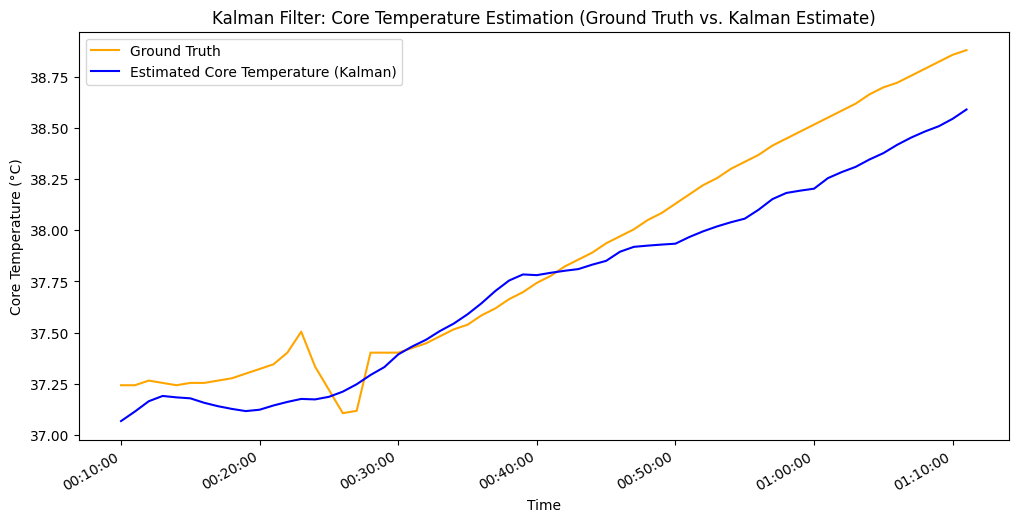

In [ ]:
# Calculate metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

mae = mean_absolute_error(data_subset["CoreTemp"], data_subset["CoreTemp_Estimate"])
rmse = np.sqrt(mean_squared_error(data_subset["CoreTemp"], data_subset["CoreTemp_Estimate"]))
mape = np.mean(np.abs((data_subset["CoreTemp"] - data_subset["CoreTemp_Estimate"]) / data_subset["CoreTemp"])) * 100
r2 = r2_score(data_subset["CoreTemp"], data_subset["CoreTemp_Estimate"])

# Print metrics
#print(f"Metrics for Participant {combo['Participant']}, Condition {combo['Condition']}, Activity {combo['Activity code']}:")
#print(f"Metrics for Participant {combo['Participant']}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
print(f"R² Score: {r2:.4f}")



import matplotlib.dates as mdates

# Convert Time to datetime for plotting
timestamps = pd.to_datetime(data_subset["Time"], format='%H:%M:%S')

plt.figure(figsize=(12, 6))
plt.plot(timestamps, data_subset["CoreTemp"], label="Ground Truth ", color='orange')
plt.plot(timestamps, data_subset["CoreTemp_Estimate"], label="Estimated Core Temperature (Kalman)", color='blue')
plt.xlabel("Time")
plt.ylabel("Core Temperature (°C)")
plt.title("Kalman Filter: Core Temperature Estimation (Ground Truth vs. Kalman Estimate)")
plt.legend()

# Format x-axis
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
plt.gcf().autofmt_xdate()

plt.show()

Metrics for Participant 8
Mean Absolute Error (MAE): 0.3886
Root Mean Squared Error (RMSE): 0.4275
Mean Absolute Percentage Error (MAPE): 1.04%
R² Score: 0.2248


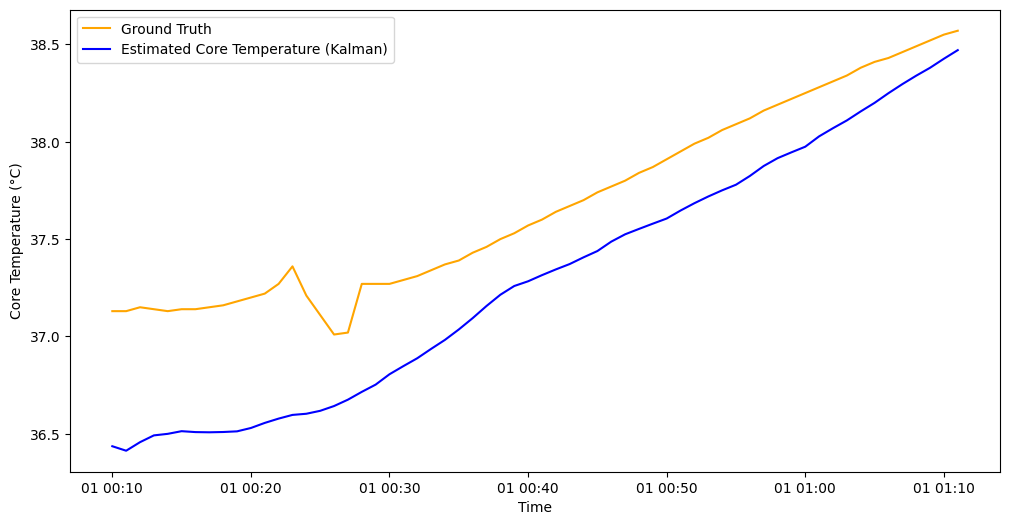

Metrics for Participant 7
Mean Absolute Error (MAE): 0.3057
Root Mean Squared Error (RMSE): 0.3428
Mean Absolute Percentage Error (MAPE): 0.80%
R² Score: 0.5520


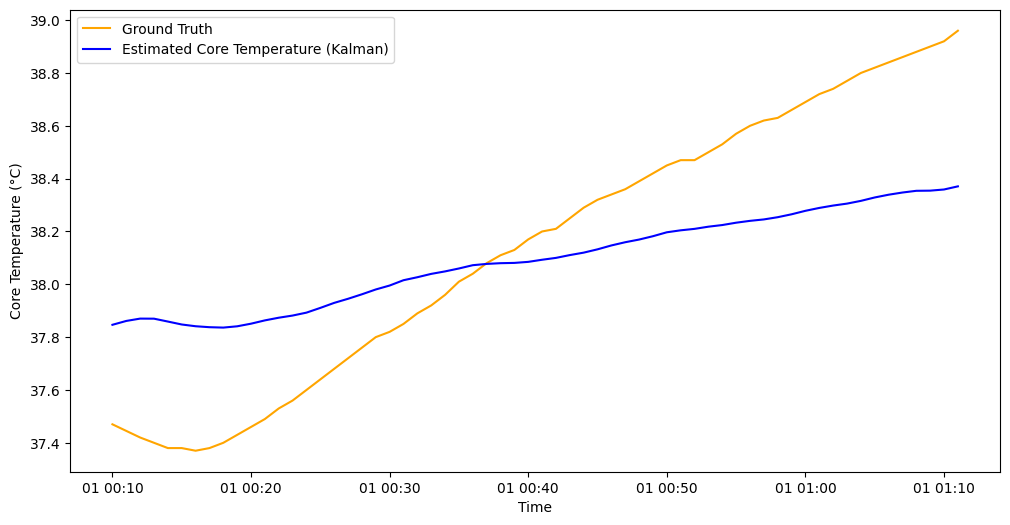

Metrics for Participant 6
Mean Absolute Error (MAE): 0.2485
Root Mean Squared Error (RMSE): 0.2800
Mean Absolute Percentage Error (MAPE): 0.65%
R² Score: 0.8432


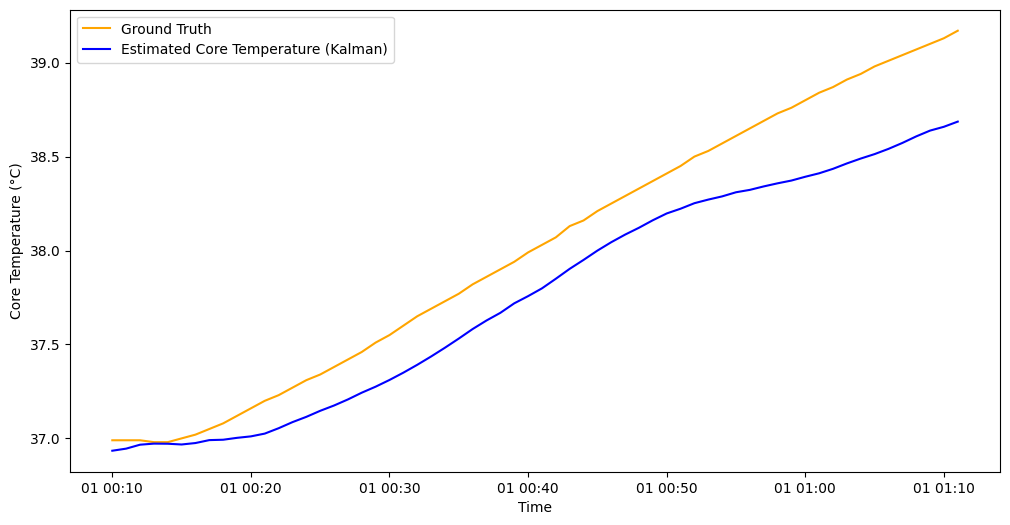

Metrics for Participant 18
Mean Absolute Error (MAE): 0.3436
Root Mean Squared Error (RMSE): 0.3618
Mean Absolute Percentage Error (MAPE): 0.92%
R² Score: 0.5508


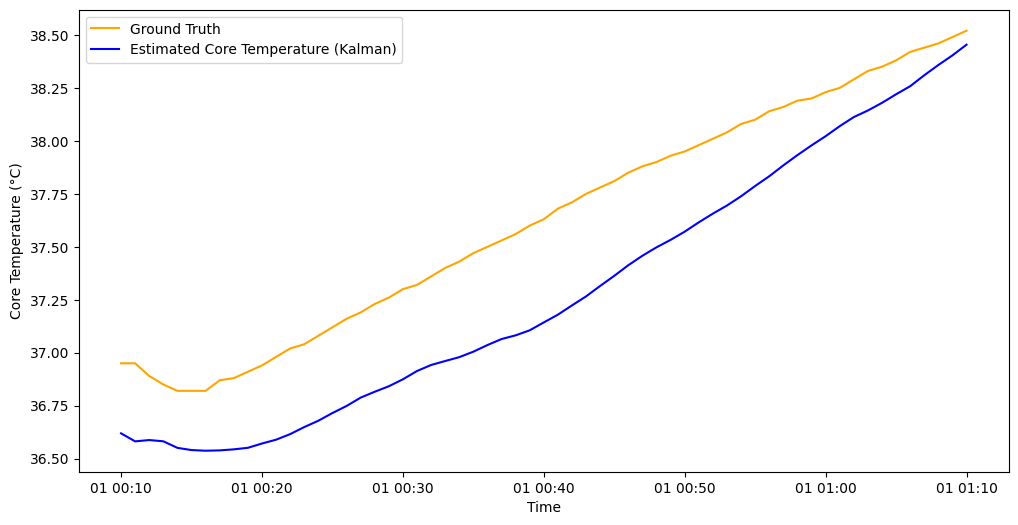

Metrics for Participant 11
Mean Absolute Error (MAE): 0.2176
Root Mean Squared Error (RMSE): 0.2270
Mean Absolute Percentage Error (MAPE): 0.57%
R² Score: 0.6484


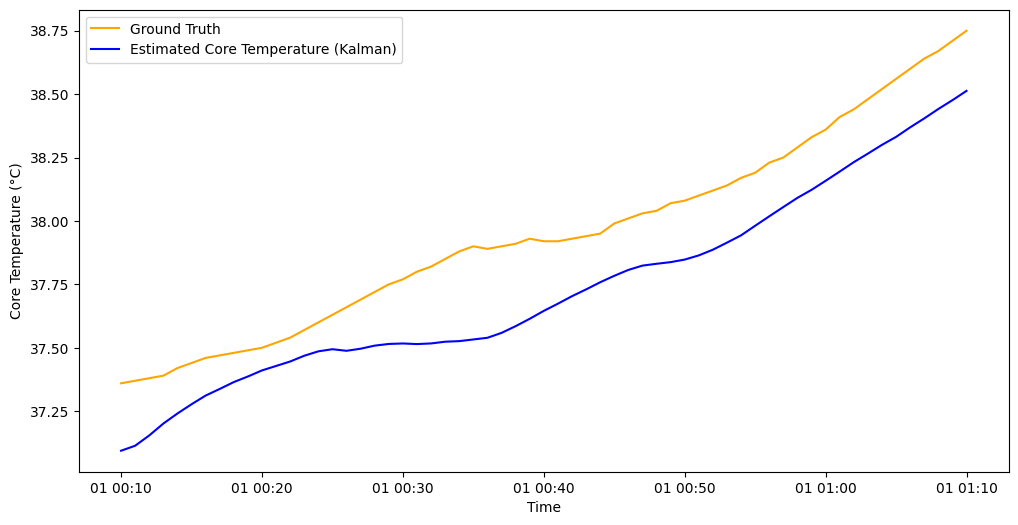

Metrics for Participant 2
Mean Absolute Error (MAE): 0.3301
Root Mean Squared Error (RMSE): 0.3963
Mean Absolute Percentage Error (MAPE): 0.88%
R² Score: -0.2152


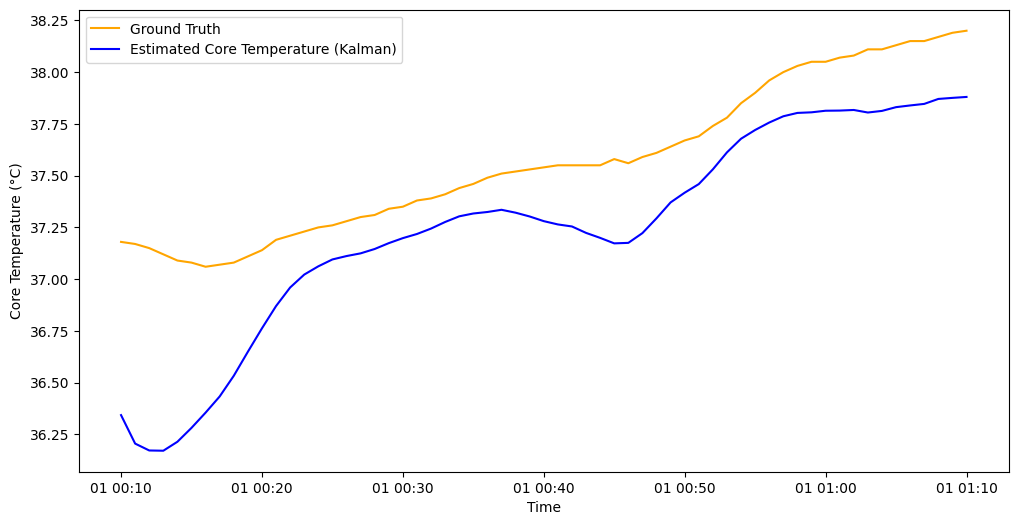

Metrics for Participant 17
Mean Absolute Error (MAE): 0.3524
Root Mean Squared Error (RMSE): 0.4034
Mean Absolute Percentage Error (MAPE): 0.94%
R² Score: 0.0508


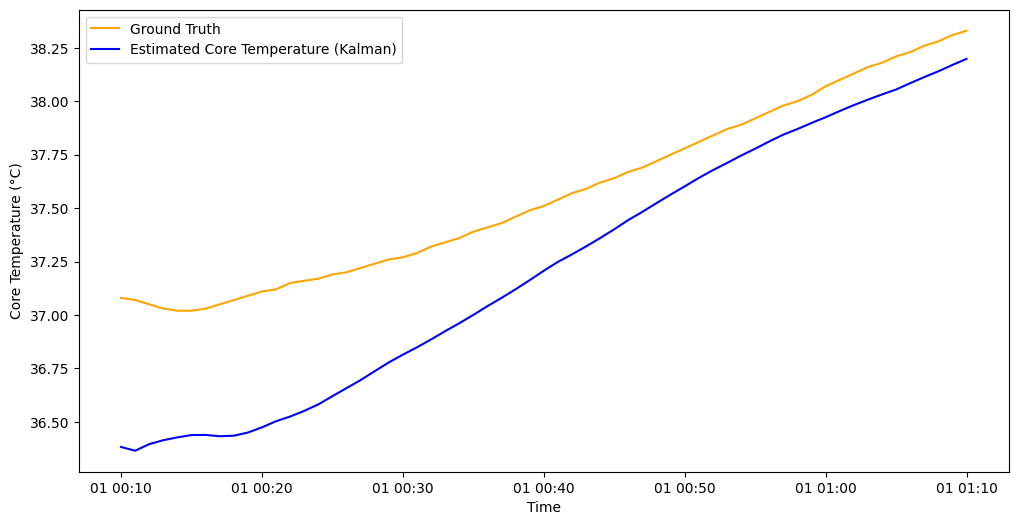

Metrics for Participant 17
Mean Absolute Error (MAE): 0.2463
Root Mean Squared Error (RMSE): 0.2560
Mean Absolute Percentage Error (MAPE): 0.65%
R² Score: 0.5943


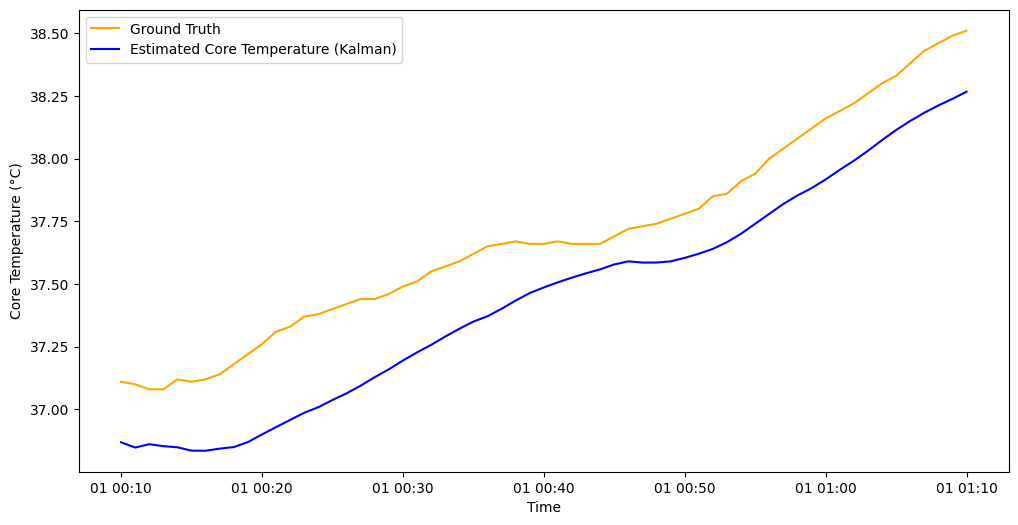

Metrics for Participant 13
Mean Absolute Error (MAE): 0.3468
Root Mean Squared Error (RMSE): 0.4280
Mean Absolute Percentage Error (MAPE): 0.93%
R² Score: -0.2537


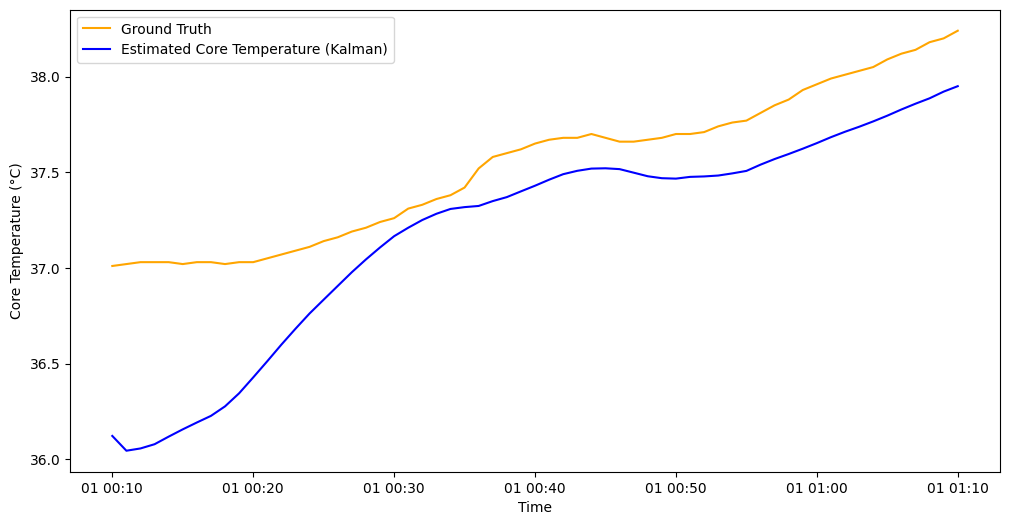

Metrics for Participant 18
Mean Absolute Error (MAE): 0.1940
Root Mean Squared Error (RMSE): 0.2283
Mean Absolute Percentage Error (MAPE): 0.51%
R² Score: 0.8095


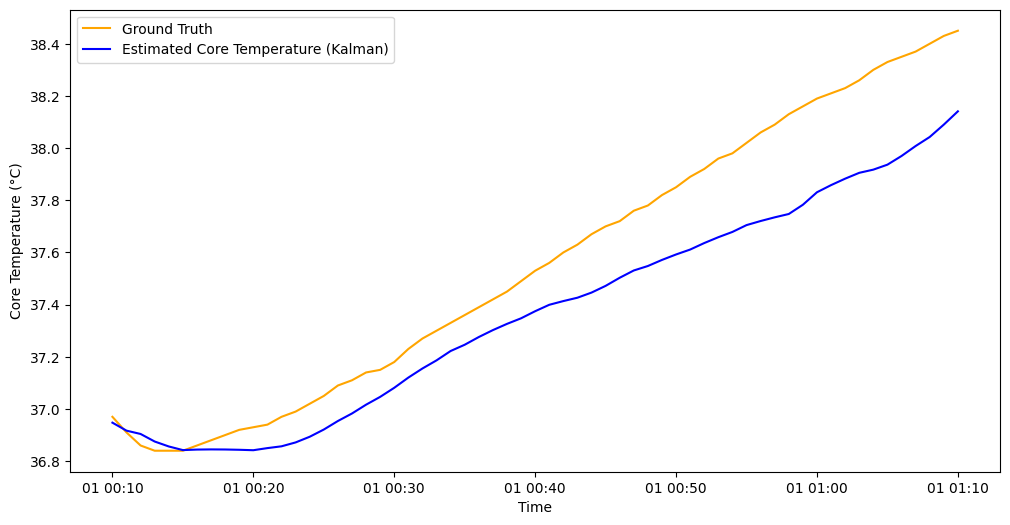

In [ ]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


# Define the top combinations
top_combinations = [
    {"Participant": 8, "Condition": 2, "Activity code": 5},
    {"Participant": 7, "Condition": 2, "Activity code": 5},
    {"Participant": 6, "Condition": 2, "Activity code": 5},
    {"Participant": 18, "Condition": 1, "Activity code": 5},
    {"Participant": 11, "Condition": 3, "Activity code": 5},
    {"Participant": 2, "Condition": 3, "Activity code": 5},
    {"Participant": 17, "Condition": 2, "Activity code": 5},
    {"Participant": 17, "Condition": 3, "Activity code": 5},
    {"Participant": 13, "Condition": 3, "Activity code": 5},
    {"Participant": 18, "Condition": 2, "Activity code": 5},
]

# Loop through each combination
results = []

for combo in top_combinations:
    # Subset the dataset
    subset_data = data[
        (data['Participant'] == combo["Participant"]) &
        (data['Condition'] == combo["Condition"]) &
        (data['Activity code'] == combo["Activity code"])
    ].copy()

    # Extract relevant columns
    columns_to_use = ["Participant", "Condition", "Time", "HR", "SkinTemp hand", "CoreTemp"]
    data_subset = subset_data[columns_to_use].copy()
    data_subset["Time"] = pd.to_datetime(data_subset["Time"], format='%H:%M:%S')
    data_subset = data_subset.dropna().reset_index(drop=True)

    # Normalize data
    data_subset["HR"] = (data_subset["HR"] - data_subset["HR"].mean()) / data_subset["HR"].std()
    data_subset["SkinTemp hand"] = (data_subset["SkinTemp hand"] - data_subset["SkinTemp hand"].mean()) / data_subset["SkinTemp hand"].std()
    data_subset["CoreTemp"] = (data_subset["CoreTemp"] - data_subset["CoreTemp"].mean()) / data_subset["CoreTemp"].std()

    # Initialize Kalman filter parameters
    F = np.eye(1)
    model = LinearRegression().fit(data_subset[["HR", "SkinTemp hand"]], data_subset["CoreTemp"])
    H = np.array([model.coef_]).T
    Q = np.array([[np.var(data_subset["CoreTemp"]) * 1e-3]])
    R = np.diag([np.var(data_subset["HR"]) * 1e-1, np.var(data_subset["SkinTemp hand"]) * 1e-1])
    X = np.array([[0]])
    P = np.eye(1)

    # Kalman filtering
    core_temp_estimates = []
    for _, row in data_subset.iterrows():
        Y = [row["HR"], row["SkinTemp hand"]]
        X_pred, P_pred = kalman_predict(X, P, F, Q)
        X, P, K = kalman_update(X_pred, P_pred, Y, H, R)
        core_temp_estimates.append(X[0, 0])

    # De-normalize estimates
    CoreTemp_mean = subset_data["CoreTemp"].mean()
    CoreTemp_std = subset_data["CoreTemp"].std()
    data_subset["CoreTemp_Estimate"] = (np.array(core_temp_estimates) * CoreTemp_std) + CoreTemp_mean
    data_subset["CoreTemp"] = (data_subset["CoreTemp"] * CoreTemp_std) + CoreTemp_mean

    # Store results
    results.append({
        "Participant": combo["Participant"],
        "Condition": combo["Condition"],
        "Activity code": combo["Activity code"],
        "Data": data_subset,
    })


    # Calculate metrics
    mae = mean_absolute_error(data_subset["CoreTemp"], data_subset["CoreTemp_Estimate"])
    rmse = np.sqrt(mean_squared_error(data_subset["CoreTemp"], data_subset["CoreTemp_Estimate"]))
    mape = np.mean(np.abs((data_subset["CoreTemp"] - data_subset["CoreTemp_Estimate"]) / data_subset["CoreTemp"])) * 100
    r2 = r2_score(data_subset["CoreTemp"], data_subset["CoreTemp_Estimate"])

    # Print metrics
    #print(f"Metrics for Participant {combo['Participant']}, Condition {combo['Condition']}, Activity {combo['Activity code']}:")
    print(f"Metrics for Participant {combo['Participant']}")
    print(f"Mean Absolute Error (MAE): {mae:.4f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
    print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
    print(f"R² Score: {r2:.4f}")

    # Store metrics in the results for further analysis if needed
    results.append({
        "Participant": combo["Participant"],
        "Condition": combo["Condition"],
        "Activity code": combo["Activity code"],
        "MAE": mae,
        "RMSE": rmse,
        "MAPE": mape,
        "R2": r2,
        "Data": data_subset
    })


    # Plot for this combination
    plt.figure(figsize=(12, 6))
    plt.plot(data_subset["Time"], data_subset["CoreTemp"], label="Ground Truth", color='orange')
    plt.plot(data_subset["Time"], data_subset["CoreTemp_Estimate"], label="Estimated Core Temperature (Kalman)", color='blue')
    plt.xlabel("Time")
    plt.ylabel("Core Temperature (°C)")
    #plt.title(f"Core Temperature Estimation for Participant {combo['Participant']}, Condition {combo['Condition']}, Activity {combo['Activity code']}")
    plt.legend()
    plt.show()

# Results contain all the processed data subsets for further analysis

In [ ]:
from sklearn.linear_model import LinearRegression
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Define function to process a single combination
def process_combination(participant, condition, activity_code, data):
    try:
        # Subset the dataset
        subset_data = data[
            (data['Participant'] == participant) &
            (data['Condition'] == condition) &
            (data['Activity code'] == activity_code)
        ].copy()

        # Extract relevant columns
        columns_to_use = ["Participant", "Condition", "Time", "HR", "SkinTemp hand", "CoreTemp"]
        data_subset = subset_data[columns_to_use].copy()
        data_subset["Time"] = pd.to_datetime(data_subset["Time"], format='%H:%M:%S')
        data_subset = data_subset.dropna().reset_index(drop=True)

        if data_subset.empty:
            print(f"Skipping Participant {participant}, Condition {condition}, Activity {activity_code} due to insufficient data.")
            return None

        # Normalize data
        data_subset["HR"] = (data_subset["HR"] - data_subset["HR"].mean()) / data_subset["HR"].std()
        data_subset["SkinTemp hand"] = (data_subset["SkinTemp hand"] - data_subset["SkinTemp hand"].mean()) / data_subset["SkinTemp hand"].std()
        data_subset["CoreTemp"] = (data_subset["CoreTemp"] - data_subset["CoreTemp"].mean()) / data_subset["CoreTemp"].std()

        # Initialize Kalman filter parameters
        F = np.eye(1)
        model = LinearRegression().fit(data_subset[["HR", "SkinTemp hand"]], data_subset["CoreTemp"])
        H = np.array([model.coef_]).T
        Q = np.array([[np.var(data_subset["CoreTemp"]) * 1e-3]])
        R = np.diag([np.var(data_subset["HR"]) * 1e-1, np.var(data_subset["SkinTemp hand"]) * 1e-1])
        X = np.array([[0]])
        P = np.eye(1)

        # Kalman filtering
        core_temp_estimates = []
        for _, row in data_subset.iterrows():
            Y = [row["HR"], row["SkinTemp hand"]]
            try:
                X_pred, P_pred = kalman_predict(X, P, F, Q)
                X, P, K = kalman_update(X_pred, P_pred, Y, H, R)
                core_temp_estimates.append(X[0, 0])
            except np.linalg.LinAlgError:
                print(f"Skipping Participant {participant}, Condition {condition}, Activity {activity_code} due to singular matrix.")
                return None

        # De-normalize estimates
        CoreTemp_mean = subset_data["CoreTemp"].mean()
        CoreTemp_std = subset_data["CoreTemp"].std()
        data_subset["CoreTemp_Estimate"] = (np.array(core_temp_estimates) * CoreTemp_std) + CoreTemp_mean
        data_subset["CoreTemp"] = (data_subset["CoreTemp"] * CoreTemp_std) + CoreTemp_mean

        # Metrics
        mae = mean_absolute_error(data_subset["CoreTemp"], data_subset["CoreTemp_Estimate"])
        rmse = np.sqrt(mean_squared_error(data_subset["CoreTemp"], data_subset["CoreTemp_Estimate"]))
        mape = np.mean(np.abs((data_subset["CoreTemp"] - data_subset["CoreTemp_Estimate"]) / data_subset["CoreTemp"])) * 100
        r2 = r2_score(data_subset["CoreTemp"], data_subset["CoreTemp_Estimate"])

        return {
            "Participant": participant,
            "Condition": condition,
            "Activity code": activity_code,
            "MAE": mae,
            "RMSE": rmse,
            "MAPE": mape,
            "R2": r2,
            "Data": data_subset,
        }

    except Exception as e:
        #print(f"Skipping Participant {participant}, Condition {condition}, Activity {activity_code} due to error: {e}")
        return None

# Loop through all unique combinations
results = []
unique_combinations = data[["Participant", "Condition", "Activity code"]].drop_duplicates()


for _, row in unique_combinations.iterrows():
    result = process_combination(row["Participant"], row["Condition"], row["Activity code"], data)
    if result is not None:
        results.append(result)

# Save results to CSV if needed
# Combine all processed data into a single DataFrame
all_results_data = pd.concat([result["Data"] for result in results if result is not None], ignore_index=True)

# Save the combined DataFrame to a single CSV file
all_results_data.to_csv("Kalman_Filter_Results.csv", index=False)



Skipping Participant 4, Condition 2, Activity 7 due to singular matrix.


#Extended Kalman Filter

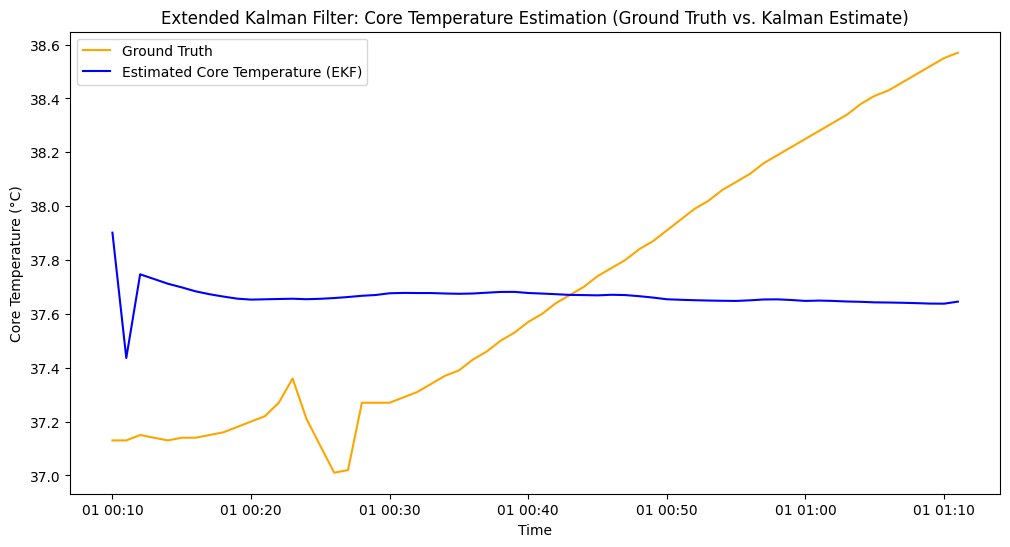

   Participant  Condition                Time        HR  SkinTemp hand  Corerectal  CoreTemp_Estimate
0            8          2 1900-01-01 00:10:00 -2.480734      -1.531304       37.13          37.901646
1            8          2 1900-01-01 00:11:00 -2.249196      -1.341731       37.13          37.436200
2            8          2 1900-01-01 00:12:00 -2.017658      -1.152459       37.15          37.746941
3            8          2 1900-01-01 00:13:00 -1.786120      -1.152459       37.14          37.729569
4            8          2 1900-01-01 00:14:00 -1.554583      -1.341731       37.13          37.712015
Metrics: {'MAE': 0.4416341970013678, 'RMSE': 0.5007335772363916, 'MAPE': 1.1694384104871662, 'R2': -0.06343612852056757}


In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
from scipy.linalg import block_diag

def extended_kalman_filter(data, participant, condition, activity_code):
    """
    Extended Kalman Filter for a specific Participant, Condition, and Activity code.

    Parameters:
        data (pd.DataFrame): Cleaned dataset.
        participant (int): Participant ID.
        condition (int): Condition ID.
        activity_code (int): Activity code.

    Returns:
        pd.DataFrame: DataFrame with Core Temperature Estimates and ground truth for visualization and evaluation.
        dict: Dictionary of metrics (MAE, RMSE, MAPE, R2 Score).
    """
    # Subset the dataset
    subset_data = data[
        (data["Participant"] == participant) &
        (data["Condition"] == condition) &
        (data["Activity code"] == activity_code)
    ].copy()

    # Extract relevant columns
    columns_to_use = ["Participant", "Condition", "Time", "HR", "SkinTemp hand", "CoreTemp"]
    data_subset = subset_data[columns_to_use].copy()

    # Convert 'Time' to datetime
    data_subset["Time"] = pd.to_datetime(data_subset["Time"], format='%H:%M:%S')

    # Drop missing values
    data_subset = data_subset.dropna().reset_index(drop=True)


    # Normalize data
    data_subset["HR"] = (data_subset["HR"] - data_subset["HR"].mean()) / data_subset["HR"].std()
    data_subset["SkinTemp hand"] = (data_subset["SkinTemp hand"] - data_subset["SkinTemp hand"].mean()) / data_subset["SkinTemp hand"].std()
    data_subset["CoreTemp"] = (data_subset["CoreTemp"] - data_subset["CoreTemp"].mean()) / data_subset["CoreTemp"].std()

    # Define nonlinear observation function (h(x))
    def h(x):
        """
        Nonlinear observation function.
        x: state (Core temperature)
        Returns: HR and SkinTemp hand
        """
        return np.array([2 * x**2 - x, np.sin(x)])

    # Define Jacobian of h(x) (H_t)
    def jacobian_h(x):
        """
        Jacobian of h(x).
        x: state (Core temperature)
        Returns: Jacobian matrix H_t
        """
        return np.array([
            [4 * x - 1],  # Partial derivative of HR w.r.t x
            [np.cos(x)]   # Partial derivative of SkinTemp hand w.r.t x
        ])

    # Kalman Filter Initialization
    X = np.array([[0]])  # Start with normalized core temp (mean = 0 after normalization)
    P = np.eye(1)        # Initial covariance matrix
    F = np.eye(1)        # State transition matrix (linear)

    Q = np.array([[1e-4]])  # Process noise covariance
    R = block_diag(0.1, 0.1)  # Measurement noise covariance

    core_temp_estimates = []
    for _, row in data_subset.iterrows():
        # Prediction Step
        X_pred = F @ X
        P_pred = F @ P @ F.T + Q

        # Observation
        Y = np.array([row["HR"], row["SkinTemp hand"]])

        # Linearization of observation function (Jacobian H_t)
        H_t = jacobian_h(X_pred[0, 0])

        # Predicted Observation
        Y_pred = h(X_pred[0, 0])

        # Innovation covariance
        S = H_t @ P_pred @ H_t.T + R

        # Kalman Gain
        K = P_pred @ H_t.T @ np.linalg.inv(S)

        # Update Step
        X = X_pred + K @ (Y - Y_pred)
        P = (np.eye(len(P_pred)) - K @ H_t) @ P_pred

        # Store the estimate
        core_temp_estimates.append(X[0, 0])

    # De-normalize results
    #data_subset["CoreTemp_Estimate"] = (np.array(core_temp_estimates) * core_temp_std) + core_temp_mean
    #data_subset["CoreTemp"] = (data_subset["CoreTemp"] * core_temp_std) + core_temp_mean

    # De-normalize estimates
    CoreTemp_mean = subset_data["CoreTemp"].mean()
    CoreTemp_std = subset_data["CoreTemp"].std()
    data_subset["CoreTemp_Estimate"] = (np.array(core_temp_estimates) * CoreTemp_std) + CoreTemp_mean
    data_subset["CoreTemp"] = (data_subset["CoreTemp"] * CoreTemp_std) + CoreTemp_mean

    # Metrics
    mae = mean_absolute_error(data_subset["CoreTemp"], data_subset["CoreTemp_Estimate"])
    rmse = np.sqrt(mean_squared_error(data_subset["CoreTemp"], data_subset["CoreTemp_Estimate"]))
    mape = np.mean(np.abs((data_subset["CoreTemp"] - data_subset["CoreTemp_Estimate"]) / data_subset["CoreTemp"])) * 100
    r2 = r2_score(data_subset["CoreTemp"], data_subset["CoreTemp_Estimate"])

    metrics = {
        "MAE": mae,
        "RMSE": rmse,
        "MAPE": mape,
        "R2": r2
    }

    # Plot Results
    plt.figure(figsize=(12, 6))
    plt.plot(data_subset["Time"], data_subset["CoreTemp"], label="Ground Truth", color='orange')
    plt.plot(data_subset["Time"], data_subset["CoreTemp_Estimate"], label="Estimated Core Temperature (EKF)", color='blue')
    plt.xlabel("Time")
    plt.ylabel("Core Temperature (°C)")
    plt.title("Extended Kalman Filter: Core Temperature Estimation (Ground Truth vs. Kalman Estimate)")
    plt.legend()
    plt.show()

    return data_subset, metrics

# Apply the function to the first combination
data_subset, metrics = extended_kalman_filter(data, participant=8, condition=2, activity_code=5)
print(data_subset.head())

# Display metrics
print("Metrics:", metrics)


###Window Kalman

In [ ]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Define the window size (e.g., 5 observations)
WINDOW_SIZE = 5

def windowed_kalman_filter(subset_data):
    # Extract relevant columns
    columns_to_use = ["Participant", "Condition", "Time", "HR", "SkinTemp hand", "CoreTemp"]
    data_subset = subset_data[columns_to_use].copy()
    data_subset["Time"] = pd.to_datetime(data_subset["Time"], format='%H:%M:%S')
    data_subset = data_subset.dropna().reset_index(drop=True)

    # Normalize data
    data_subset["HR"] = (data_subset["HR"] - data_subset["HR"].mean()) / data_subset["HR"].std()
    data_subset["SkinTemp hand"] = (data_subset["SkinTemp hand"] - data_subset["SkinTemp hand"].mean()) / data_subset["SkinTemp hand"].std()
    data_subset["CoreTemp"] = (data_subset["CoreTemp"] - data_subset["CoreTemp"].mean()) / data_subset["CoreTemp"].std()

    # Initialize Kalman filter parameters
    state_dim = 1  # Only Core Temperature
    obs_dim = WINDOW_SIZE * 2  # HR and SkinTemp for each observation in the window

    F = np.eye(state_dim)  # State Transition Matrix

    # Train regression model to estimate observation matrix (H)
    X_obs = data_subset[["HR", "SkinTemp hand"]]
    y_obs = data_subset["CoreTemp"]
    model = LinearRegression().fit(X_obs, y_obs)
    weights = model.coef_

    H = np.zeros((obs_dim, state_dim))  # Observation Matrix for window
    for i in range(WINDOW_SIZE):
        H[i * 2:(i + 1) * 2, 0] = weights  # Repeat weights for each observation in the window

    Q = np.array([[np.var(data_subset["CoreTemp"]) * 1e-3]])  # Process noise covariance
    R = np.diag(
        [np.var(data_subset["HR"]) * 1e-1] * WINDOW_SIZE +
        [np.var(data_subset["SkinTemp hand"]) * 1e-1] * WINDOW_SIZE
    )  # Measurement noise covariance

    # Initialize state vector and covariance matrix
    X = np.array([[0]])  # Normalized initial state
    P = np.eye(state_dim)

    # Store results
    core_temp_estimates = []
    timestamps = []

    # Iterate through the dataset with a sliding window
    for i in range(len(data_subset) - WINDOW_SIZE + 1):
        # Define the current window
        window = data_subset.iloc[i:i + WINDOW_SIZE]
        Y_window = np.concatenate(
            [window["HR"].values, window["SkinTemp hand"].values]
        ).reshape(-1, 1)  # Shape: [WINDOW_SIZE * 2, 1]

        # Prediction step
        X_pred = F @ X
        P_pred = F @ P @ F.T + Q

        # Update step
        H_windowed = np.tile(H.T, (WINDOW_SIZE, 1))  # Extend H for the window

        # Extend P_pred to match the size of H_windowed
        P_pred_extended = np.tile(P_pred, (H_windowed.shape[0], H_windowed.shape[1]))

        # Compute Innovation Covariance (S)
        S = H_windowed @ P_pred_extended @ H_windowed.T + R

        # Compute Kalman Gain (K)
        K = P_pred_extended @ H_windowed.T @ np.linalg.inv(S)

        # Predicted Observation (Y_pred)
        Y_pred = H_windowed @ X_pred

        # Update State Estimate (X)
        X = X_pred + K @ (Y_window.flatten() - Y_pred)

        # Update Covariance Matrix (P)
        P = (np.eye(P_pred_extended.shape[0]) - K @ H_windowed) @ P_pred_extended


        # Store the result
        core_temp_estimates.append(X[0, 0])
        timestamps.append(data_subset.iloc[i + WINDOW_SIZE - 1]["Time"])

    # De-normalize estimates
    CoreTemp_mean = subset_data["CoreTemp"].mean()
    CoreTemp_std = subset_data["CoreTemp"].std()
    core_temp_estimates = np.array(core_temp_estimates) * CoreTemp_std + CoreTemp_mean

    # Prepare results dataframe
    results = pd.DataFrame({
        "Time": timestamps,
        "CoreTemp_Estimate": core_temp_estimates,
        "CoreTemp": data_subset["CoreTemp"].iloc[WINDOW_SIZE - 1:].values * CoreTemp_std + CoreTemp_mean
    })

    # Calculate metrics
    mae = mean_absolute_error(results["CoreTemp"], results["CoreTemp_Estimate"])
    rmse = np.sqrt(mean_squared_error(results["CoreTemp"], results["CoreTemp_Estimate"]))
    mape = np.mean(np.abs((results["CoreTemp"] - results["CoreTemp_Estimate"]) / results["CoreTemp"])) * 100
    r2 = r2_score(results["CoreTemp"], results["CoreTemp_Estimate"])

    metrics = {
        "MAE": mae,
        "RMSE": rmse,
        "MAPE": mape,
        "R2": r2
    }

    return results, metrics



# Example Usage
# Subset dataset for a specific participant, condition, and activity
subset_data = data[
    (data["Participant"] == 8) &
    (data["Condition"] == 2) &
    (data["Activity code"] == 5)
]

# Run windowed Kalman filter
results, metrics = windowed_kalman_filter(subset_data)

print("Windowed Kalman Filter Results:")
print(results.head())

print("Metrics:")
print(metrics)

# Visualization
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

plt.figure(figsize=(12, 6))
plt.plot(results["Time"], results["CoreTemp"], label="Ground Truth (CoreTemp)", color='orange')
plt.plot(results["Time"], results["CoreTemp_Estimate"], label="Estimated Core Temperature (Windowed Kalman)", color='blue')
plt.xlabel("Time")
plt.ylabel("Core Temperature (°C)")
plt.title("Core Temperature Estimation (Windowed Kalman Filter)")
plt.legend()

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
plt.gcf().autofmt_xdate()
plt.show()